In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

In [ ]:
# Download ETTh1 file from [Google Drive](https://drive.google.com/corp/drive/folders/1ZOYpTUa82_jCcxIdTmyr0LXQfvaM9vIy) and put it under data/

In [5]:
filepath = ('data/ETTh1.csv')

df_raw = pd.read_csv(filepath)
df_raw.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


## DataLoader

Самое сложное в применении моделей глубокого обучения для прогнозирования временных рядов - это, пожалуй, форматирование набора данных для подачи в нейронную сеть.

Поэтому первым шагом является создание класса DataLoader, который обрабатывает все преобразования набора данных. Этот класс инициализируется размером пакета, длиной входной последовательности, длиной выходной последовательности (горизонт) и объектом target.

In [7]:
class DataLoader:

    def __init__(self, batch_size, seq_len, pred_len):
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.target_slice = slice(0, None)

        self._read_data()
    
    def _read_data(self):
        filepath = ('data/ETTh1.csv')

        df_raw = pd.read_csv(filepath)
        df = df_raw.set_index('date')

        # split train/valid/test
        n = len(df)
        train_end = int(n * 0.7)
        val_end = n - int(n * 0.2)
        test_end = n

        train_df = df[:train_end]
        val_df = df[train_end - self.seq_len : val_end]
        test_df = df[val_end - self.seq_len : test_end]

        # standardize by training set
        self.scaler = StandardScaler()
        self.scaler.fit(train_df.values)

        def scale_df(df, scaler):
            data = scaler.transform(df.values)
            return pd.DataFrame(data, index=df.index, columns=df.columns)

        self.train_df = scale_df(train_df, self.scaler)
        self.val_df = scale_df(val_df, self.scaler)
        self.test_df = scale_df(test_df, self.scaler)
        self.n_feature = self.train_df.shape[-1]

    def _split_window(self, data):
        inputs = data[:, : self.seq_len, :]
        labels = data[:, self.seq_len :, self.target_slice]

        inputs.set_shape([None, self.seq_len, None])
        labels.set_shape([None, self.pred_len, None])
        return inputs, labels

    def _make_dataset(self, data, shuffle=True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=(self.seq_len + self.pred_len),
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=self.batch_size,
        )
        ds = ds.map(self._split_window)
        return ds

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

    def get_train(self, shuffle=True):
        return self._make_dataset(self.train_df, shuffle=shuffle)

    def get_val(self):
        return self._make_dataset(self.val_df, shuffle=False)

    def get_test(self):
        return self._make_dataset(self.test_df, shuffle=False)

In [8]:
data_loader = DataLoader(batch_size=32, seq_len=512, pred_len=96)

train_data = data_loader.get_train()
val_data = data_loader.get_val()
test_data = data_loader.get_test()

2024-10-20 19:13:11.227431: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-10-20 19:13:11.227583: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-20 19:13:11.227601: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-20 19:13:11.228177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-20 19:13:11.228878: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Build model

In [14]:
def res_block(inputs, ff_dim):

    norm = layers.BatchNormalization

    # Time mixing
    x = norm(axis=[-2, -1])(inputs)
    x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
    x = layers.Dense(x.shape[-1], activation='relu')(x)
    x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Input Length, Channel]
    x = layers.Dropout(0.7)(x)
    res = x + inputs

    # Feature mixing
    x = norm(axis=[-2, -1])(res)
    x = layers.Dense(ff_dim, activation='relu')(x)  # [Batch, Input Length, FF_Dim]
    x = layers.Dropout(0.7)(x)
    x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
    x = layers.Dropout(0.7)(x)
    return x + res

In [15]:
def build_model(
    input_shape,
    pred_len,
    n_block,
    ff_dim,
    target_slice,
):

    inputs = tf.keras.Input(shape=input_shape)
    x = inputs  # [Batch, Input Length, Channel]
    for _ in range(n_block):
        x = res_block(x, ff_dim)

    if target_slice:
        x = x[:, :, target_slice]

    # Temporal projection
    x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
    x = layers.Dense(pred_len)(x)  # [Batch, Channel, Output Length]
    outputs = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Output Length, Channel])

    return tf.keras.Model(inputs, outputs)

In [16]:
model = build_model(
    input_shape=(512, data_loader.n_feature),
    pred_len=96,
    n_block=8,
    ff_dim=64,
    target_slice=data_loader.target_slice
)

## Train model

In [89]:
tf.keras.utils.set_random_seed(42)

optimizer = tf.keras.optimizers.Adam(1e-4)

model.compile(optimizer, loss='mse', metrics=['mae', 'mse'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tsmixer_checkpoints/',
    vebose=1,
    save_best_only=True,
    save_weights_only=True
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)


In [90]:
history = model.fit(
    train_data,
    epochs= 30,
    validation_data=val_data,
    callbacks=[checkpoint_callback, early_stop_callback]
)

Epoch 1/30


2024-10-20 20:49:23.275497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - ETA: 0s - loss: 0.8912 - mae: 0.7194 - mse: 0.8912

2024-10-20 20:50:01.112065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


363/363 [==============================] - 45s 99ms/step - loss: 0.8912 - mae: 0.7194 - mse: 0.8912 - val_loss: 1.3755 - val_mae: 0.9583 - val_mse: 1.3755
Epoch 2/30
363/363 [==============================] - 30s 82ms/step - loss: 0.7163 - mae: 0.6455 - mse: 0.7163 - val_loss: 1.4735 - val_mae: 0.9938 - val_mse: 1.4735
Epoch 3/30
363/363 [==============================] - 29s 80ms/step - loss: 0.6284 - mae: 0.6002 - mse: 0.6284 - val_loss: 1.5229 - val_mae: 1.0134 - val_mse: 1.5229
Epoch 4/30
363/363 [==============================] - 30s 83ms/step - loss: 0.5697 - mae: 0.5674 - mse: 0.5697 - val_loss: 1.5558 - val_mae: 1.0157 - val_mse: 1.5558
Epoch 5/30
363/363 [==============================] - 29s 81ms/step - loss: 0.5217 - mae: 0.5394 - mse: 0.5217 - val_loss: 1.5373 - val_mae: 1.0131 - val_mse: 1.5373
Epoch 6/30
363/363 [==============================] - 28s 78ms/step - loss: 0.4889 - mae: 0.5191 - mse: 0.4889 - val_loss: 1.4246 - val_mae: 0.9561 - val_mse: 1.4246
Epoch 7/30
363/

In [91]:
best_epoch = np.argmin(history.history['val_loss'])

model.load_weights("tsmixer_checkpoints/")

In [92]:
predictions = model.predict(test_data)

scaled_preds = predictions[-1,:,:]

2024-10-20 20:53:02.568327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


106/106 [==============================] - 6s 45ms/step


In [93]:
cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

scaled_preds_df = pd.DataFrame(scaled_preds)
scaled_preds_df.columns = cols

preds = data_loader.inverse_transform(scaled_preds)

preds_df = pd.DataFrame(preds)
preds_df.columns = cols

In [94]:
preds_df.shape

(96, 7)

In [95]:
model.metrics_names

['loss', 'mae', 'mse']

In [96]:
model.evaluate(test_data)

106/106 [==============================] - 5s 48ms/step - loss: 1.7356 - mae: 1.0666 - mse: 1.7356


[1.7355589866638184, 1.0666158199310303, 1.7355587482452393]

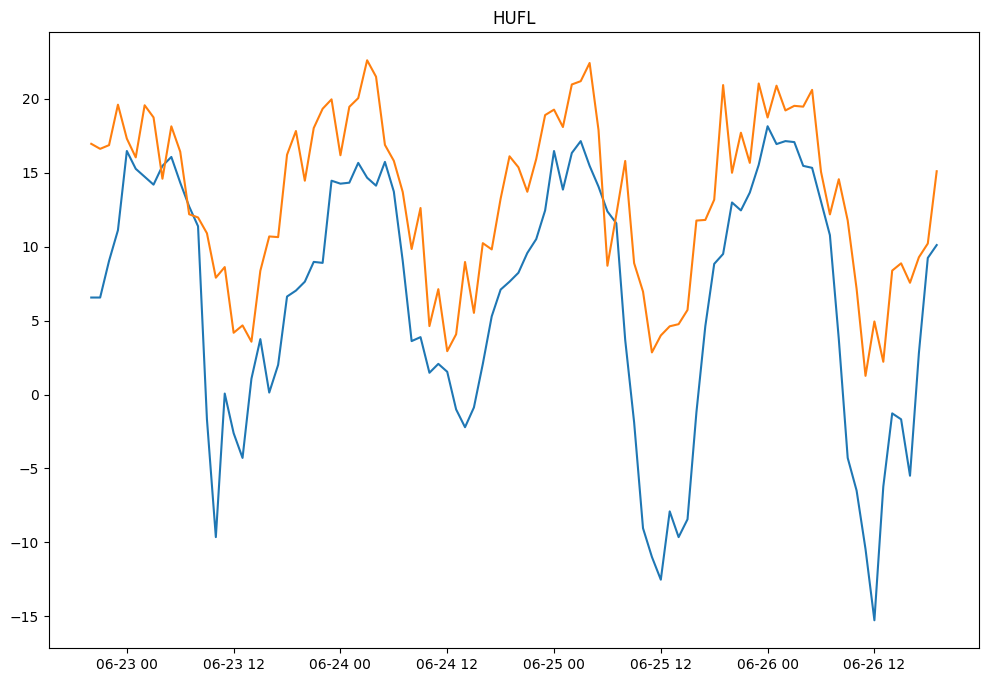

In [112]:
name = 'HUFL'
plt.figure(figsize=(12, 8))
dt_series = pd.to_datetime(df_raw['date'][-96:])
plt.plot(dt_series, df_raw[name][-96:])
plt.plot(dt_series, preds_df[name][-96:])
plt.title(name)
plt.show()